# Creating a Correlation Graph for A and B Channel Data

Purpose is to create a 4 by 4 grid of correlation plots of each sensor

- X is B PM2.5_atm, Y is A Pm2.5_atm
- 24 hour average
- Mark outliers red that 1) exceed absolute difference 5 ug/m3 and/or 2) exceed 16% error with channel A baseline

https://cfpub.epa.gov/si/si_public_record_Report.cfm?Lab=CEMM&dirEntryId=348236

## Setup and Importing Data

First import required packages.

In [1]:
import pandas as pd
import seaborn as sns

Then import the preprocessed data. Channel A data is stored in a dataframe named data_A, and channel B data is stored in the dataframe data_B.

In [2]:
data_A = pd.read_parquet('../data/interim/PurpleAir MASTER realtime individual.parquet').drop(columns=['entry_id'])
print('Primary_A imported')
data_B = pd.read_parquet('../data/interim/PurpleAir B MASTER realtime individual.parquet')[['PM2.5_ATM_ug/m3']]
print('Primary_B imported')

Primary_A imported
Primary_B imported


## Performing Resampling on DataFrame

Both of these dataframes use a multiindex consisting of (sensor_name,created_at). So resampling must be performed in a specific way in order to obtain the intend result. If you just use df.resample(), it will average all the sensors together, essentially erasing the sensor_name component of the index. However, we get daily averaged data PER CITY, so we utilize the methods described in this [stackoverflow answer](https://stackoverflow.com/questions/15799162/resampling-within-a-pandas-multiindex) to do exactly that using groupby instructions. I also just appended a .rename() to each line, because it was more convenient than writing another variable assignment (like data_A = data_A.rename()).

In [20]:
data_A

PM1.0_CF1_ug/m3  PM2.5_CF1_ug/m3  \
sensor_name created_at                                                    
PA_II_0D9C  2019-12-31 00:00:00-06:00              NaN              NaN   
            2020-01-01 00:00:00-06:00         9.148278        13.834861   
            2020-01-02 00:00:00-06:00        12.859681        20.693389   
            2020-01-03 00:00:00-06:00         2.121110         2.978492   
            2020-01-04 00:00:00-06:00         1.652295         2.262434   
...                                                ...              ...   
PA_II_E6D8  2020-09-11 00:00:00-05:00         6.660376        10.199513   
            2020-09-12 00:00:00-05:00         8.261611        11.273667   
            2020-09-13 00:00:00-05:00         6.050153         8.314361   
            2020-09-14 00:00:00-05:00         8.748997        12.676017   
            2020-09-15 00:00:00-05:00              NaN              NaN   

                                       PM10.0_CF1_ug/m3  UptimeMinutes  \
sensor_name created_at                                                   
PA_II_0D9C  2019-12-31 00:00:00-06:00               NaN            NaN   
            2020-01-01 00:00:00-06:00         14.895097   37115.000000   
            2020-01-02 00:00:00-06:00         22.503903   38555.000000   
            2020-01-03 00:00:00-06:00          3.166046   40009.802276   
            2020-01-04 00:00:00-06:00          2.403213   41433.216968   
...                                                 ...            ...   
PA_II_E6D8  2020-09-11 00:00:00-05:00         10.894395   26590.333797   
            2020-09-12 00:00:00-05:00         11.628292   28032.000000   
            2020-09-13 00:00:00-05:00          8.612611   29472.000000   
            2020-09-14 00:00:00-05:00         13.164220   30911.894150   
            2020-09-15 00:00:00-05:00               NaN            NaN   

                                        RSSI_dbm  Temperature_F  Humidity_%  \
sensor_name created_at                                                        
PA_II_0D9C  2019-12-31 00:00:00-06:00        NaN            NaN         NaN   
            2020-01-01 00:00:00-06:00 -48.780556      59.916667   37.716667   
            2020-01-02 00:00:00-06:00 -48.769444      60.531944   61.901389   
            2020-01-03 00:00:00-06:00 -49.426743      61.540541   43.268848   
            2020-01-04 00:00:00-06:00 -48.796940      62.089013   30.201669   
...                                          ...            ...         ...   
PA_II_E6D8  2020-09-11 00:00:00-05:00 -75.332406      78.428373   55.204451   
            2020-09-12 00:00:00-05:00 -36.520833      87.895833   47.351389   
            2020-09-13 00:00:00-05:00 -41.208333      89.794444   45.320833   
            2020-09-14 00:00:00-05:00 -60.044568      87.661560   48.487465   
            2020-09-15 00:00:00-05:00        NaN            NaN         NaN   

                                       Channel A PM2.5 (ug/m3)       lat  \
sensor_name created_at                                                     
PA_II_0D9C  2019-12-31 00:00:00-06:00                      NaN       NaN   
            2020-01-01 00:00:00-06:00                13.821972  30.28559   
            2020-01-02 00:00:00-06:00                20.649250  30.28559   
            2020-01-03 00:00:00-06:00                 2.978492  30.28559   
            2020-01-04 00:00:00-06:00                 2.262434  30.28559   
...                                                        ...       ...   
PA_II_E6D8  2020-09-11 00:00:00-05:00                10.157719  30.28941   
            2020-09-12 00:00:00-05:00                11.273667  30.28941   
            2020-09-13 00:00:00-05:00                 8.314361  30.28941   
            2020-09-14 00:00:00-05:00                12.675738  30.28941   
            2020-09-15 00:00:00-05:00                      NaN       NaN   

                                             lon  
sensor_name created_at          

In [3]:
# https://stackoverflow.com/questions/15799162/resampling-within-a-pandas-multiindex
def resample_by_sensor(df):
    grouper = df.groupby([pd.Grouper(level='sensor_name'),pd.Grouper(level='created_at',freq='D')])
    data_averaged = grouper.mean()
    insufficient_timepoints = grouper.count() < grouper.count().max()*0.9
    data = data_averaged[~insufficient_timepoints]
    return data

In [11]:
data_A = resample_by_sensor(data_A).rename(columns={'PM2.5_ATM_ug/m3':'Channel A PM2.5 (ug/m3)'})
data_B = resample_by_sensor(data_B).rename(columns={'PM2.5_ATM_ug/m3':'Channel B PM2.5 (ug/m3)'})

data = pd.concat([data_A,data_B], axis=1, join='inner')

## Data Analysis

Now that our A and B dataframes are ready, we will combine them and perform some calculations:
1. Do percent error with A data as theoretical
2. Determine if each value is an outlier or not with boolean output
3. Bound of 40 on x-axis and y-axis because some outliers reach the thousands and make it hard to read relevant data

In [15]:
def scatter_facet_grid(data,x_col='Channel B PM2.5 (ug/m3)',y_col='Channel A PM2.5 (ug/m3)', hue='outlier', bound=None):
    if bound is not None:
        data = data.loc[(data[y_col]<bound) &(data[x_col]<bound)]
    g = sns.FacetGrid(data.reset_index().set_index('created_at'), col="sensor_name", hue=hue, palette=['blue','red'], col_wrap=5)
    g.map(sns.scatterplot,x_col,y_col)

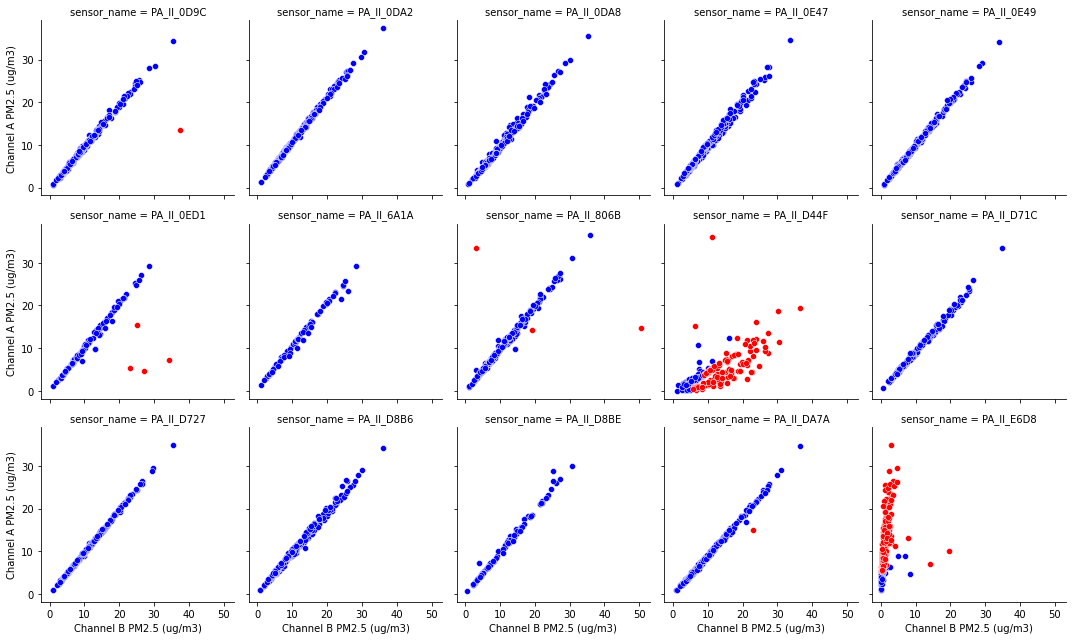

In [17]:
def mark_outliers(data):
    diff =  abs(data['Channel A PM2.5 (ug/m3)']-data['Channel B PM2.5 (ug/m3)'])
    pct_error = diff*100/data['Channel A PM2.5 (ug/m3)']
    data['outlier'] = (diff > 5) & (pct_error > 16)
    return data

marked_data = mark_outliers(data)
scatter_facet_grid(marked_data, bound=70)

## Use Seaborn to Create a Scatter Facet Grid
https://seaborn.pydata.org/tutorial/axis_grids.html


In [234]:
def remove_marked_outliers(data):
    data_cleaned = data.loc[~data.loc[:,'outlier']]
    return data_cleaned

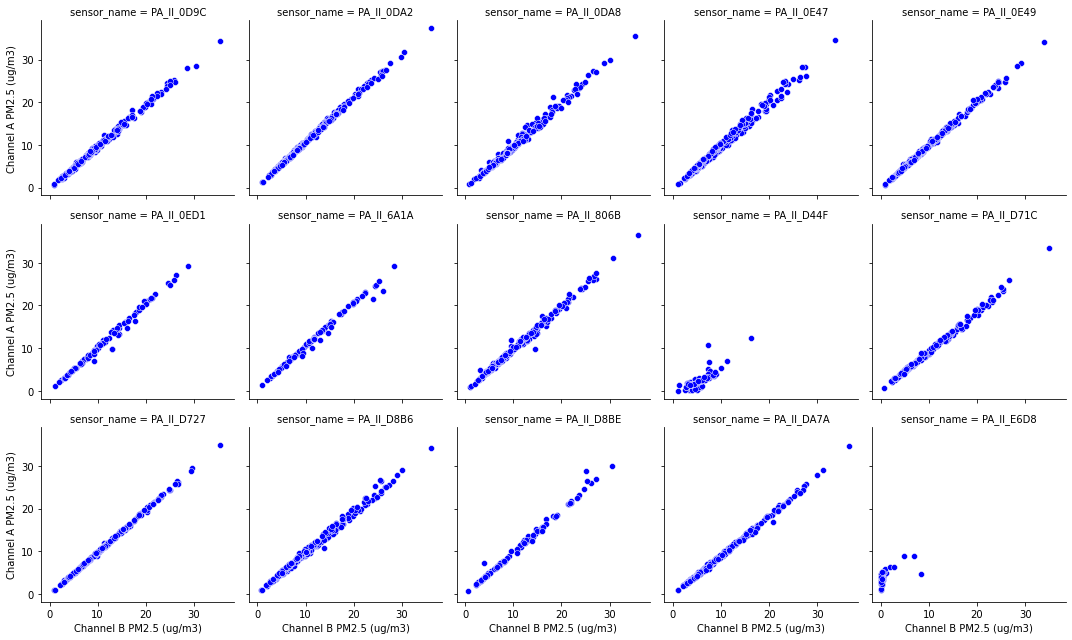

In [240]:
data_cleaned = remove_marked_outliers(data)
scatter_facet_grid(data_cleaned)


In [241]:
data_cleaned['Channel A PM2.5 (ug/m3)'].max()

3332.4488321678327